# Rental Price Prediction

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Preprocessing of Numerical and Categorical Data
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Read Data
Main: rentals_dataset.csv

Supplemented datasets:
1. hdb_rentals
2. hdb_locations
3. train_locations
4. mrt_locations
5. busstop_locations
6. school_locations
7. moeschools (Generalinformationofschools.csv)
8. intschool_locations
9. shopping_locations

Other Available Datasets:
- hdb_mapping_price_per_sqm.csv
- hdb_mapping_units.csv
- hdb_rentals.csv
- hdb_resales.csv
- mrt_lrt_data.csv
- new_resales.csv
- old_resales.csv

In [4]:
rentals_dataset = pd.read_csv('rentals_dataset.csv', index_col=0)

In [5]:
#Check for Missing Values
print(rentals_dataset.isna().any()) 

date                  False
town                  False
block                 False
street_name           False
flat_type             False
monthly_rent          False
flat_type_group       False
region                False
lat                   False
lng                   False
postal                False
property_age          False
avg_floor_area_sqm    False
price_sqm             False
nearest_MRT           False
mrt_dist              False
nearest_shopping      False
shopping_dist         False
nearest_intschool     False
intschool_dist        False
nearest_hawker        False
hawker_dist           False
dtype: bool


In [6]:
rentals_dataset['monthly_rent'].describe()

count    104604.000000
mean       2559.120789
std         716.748883
min         300.000000
25%        2000.000000
50%        2400.000000
75%        3000.000000
max        7600.000000
Name: monthly_rent, dtype: float64

### Data Preprocessing

Identify useful features and drop unnecessary features from the df

In [7]:
from datetime import datetime

# Transform date to more usable format
rentals_dataset['date'] = pd.to_datetime(rentals_dataset['date'])
reference_date = datetime(2023, 12, 31)
rentals_dataset['year'] = rentals_dataset['date'].dt.year

# Calculate the difference in months
rentals_dataset['months_since_signedrental'] = (
    (rentals_dataset['date'].dt.year - reference_date.year) * 12 +
    (rentals_dataset['date'].dt.month - reference_date.month)
)
rentals_dataset.head()

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,nearest_MRT,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist,year,months_since_signedrental
0,2021-01-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,...,Yio Chu Kang,1.329716,Broadway Plaza,0.929260,NANYANG POLYTECHNIC,1.529100,Blks 160/162 Ang Mo Kio Ave 4,0.244028,2021,-35
1,2021-01-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,...,Ang Mo Kio,1.365741,Broadway Plaza,0.954735,NANYANG POLYTECHNIC,1.607337,Blks 160/162 Ang Mo Kio Ave 4,0.344891,2021,-35
2,2021-01-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,...,Ang Mo Kio,1.270434,Broadway Plaza,0.868254,NANYANG POLYTECHNIC,1.562581,Blks 160/162 Ang Mo Kio Ave 4,0.357068,2021,-35
3,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,...,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847,2021,-35
4,2021-01-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,...,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847,2021,-35


In [8]:
# Reduced data set to drop columns that might not be useful for the initial model
reduced_df = rentals_dataset.drop(columns=['date','block','flat_type_group', 'postal','region', 'street_name','lat','lng',
                                          'nearest_MRT','nearest_intschool','nearest_shopping','nearest_hawker',
                                           'price_sqm','year'
                                         ])

reduced_df.head()

,town,flat_type,monthly_rent,property_age,avg_floor_area_sqm,mrt_dist,shopping_dist,intschool_dist,hawker_dist,months_since_signedrental
0,ANG MO KIO,4 ROOM,2000,45.0,92.0,1.329716,0.929260,1.529100,0.244028,-35
1,ANG MO KIO,3 ROOM,1750,45.0,78.2,1.365741,0.954735,1.607337,0.344891,-35
2,ANG MO KIO,3 ROOM,1750,45.0,74.5,1.270434,0.868254,1.562581,0.357068,-35
3,ANG MO KIO,5 ROOM,2230,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35
4,ANG MO KIO,5 ROOM,2450,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35


In [9]:
numerical_df = reduced_df.select_dtypes(exclude=['object'])
numerical_df

,monthly_rent,property_age,avg_floor_area_sqm,mrt_dist,shopping_dist,intschool_dist,hawker_dist,months_since_signedrental
0,2000,45.0,92.0,1.329716,0.929260,1.529100,0.244028,-35
1,1750,45.0,78.2,1.365741,0.954735,1.607337,0.344891,-35
2,1750,45.0,74.5,1.270434,0.868254,1.562581,0.357068,-35
3,2230,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35
4,2450,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35
...,...,...,...,...,...,...,...,...
109314,4100,23.0,89.3,0.623560,0.786134,0.591196,0.782664,0
109315,3300,23.0,103.0,0.296640,0.232765,2.184021,2.932362,0
109316,2950,30.0,106.2,0.319505,0.327919,2.742494,0.661868,0
109317,3200,36.0,86.5,0.885971,0.964711,1.233403,0.635330,0


### Checking for hints of multicollinearity

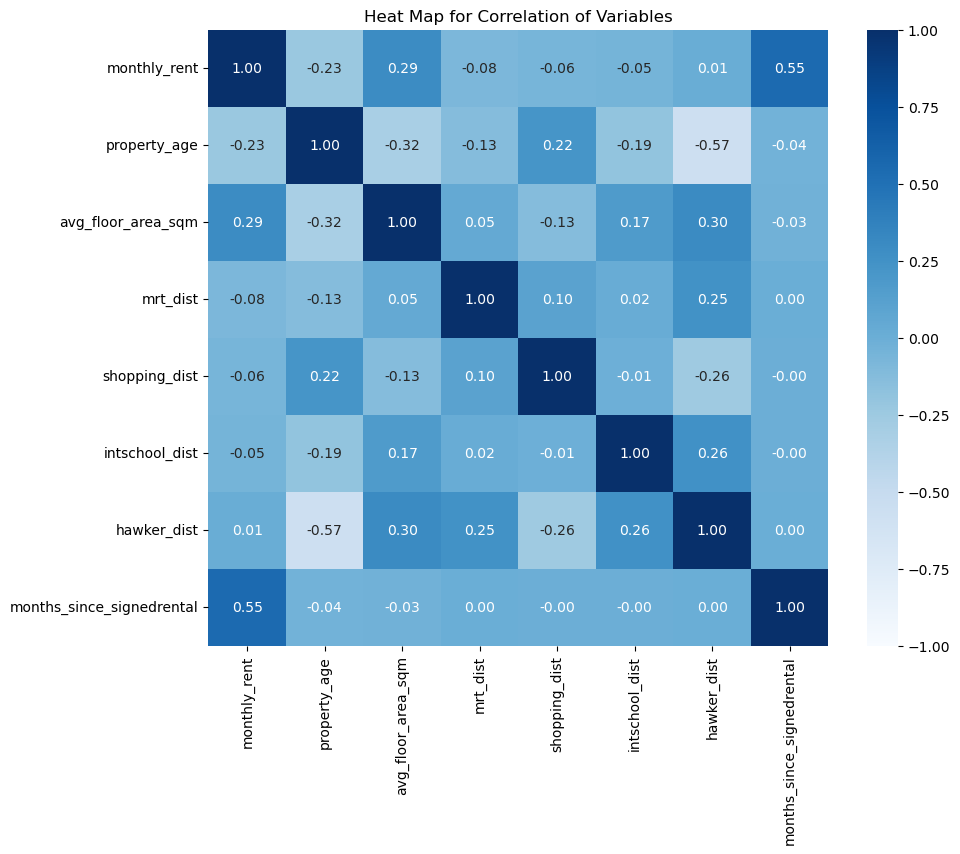

In [10]:
corr_matrix = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='Blues')
plt.title('Heat Map for Correlation of Variables')
plt.show()

### Pairplots

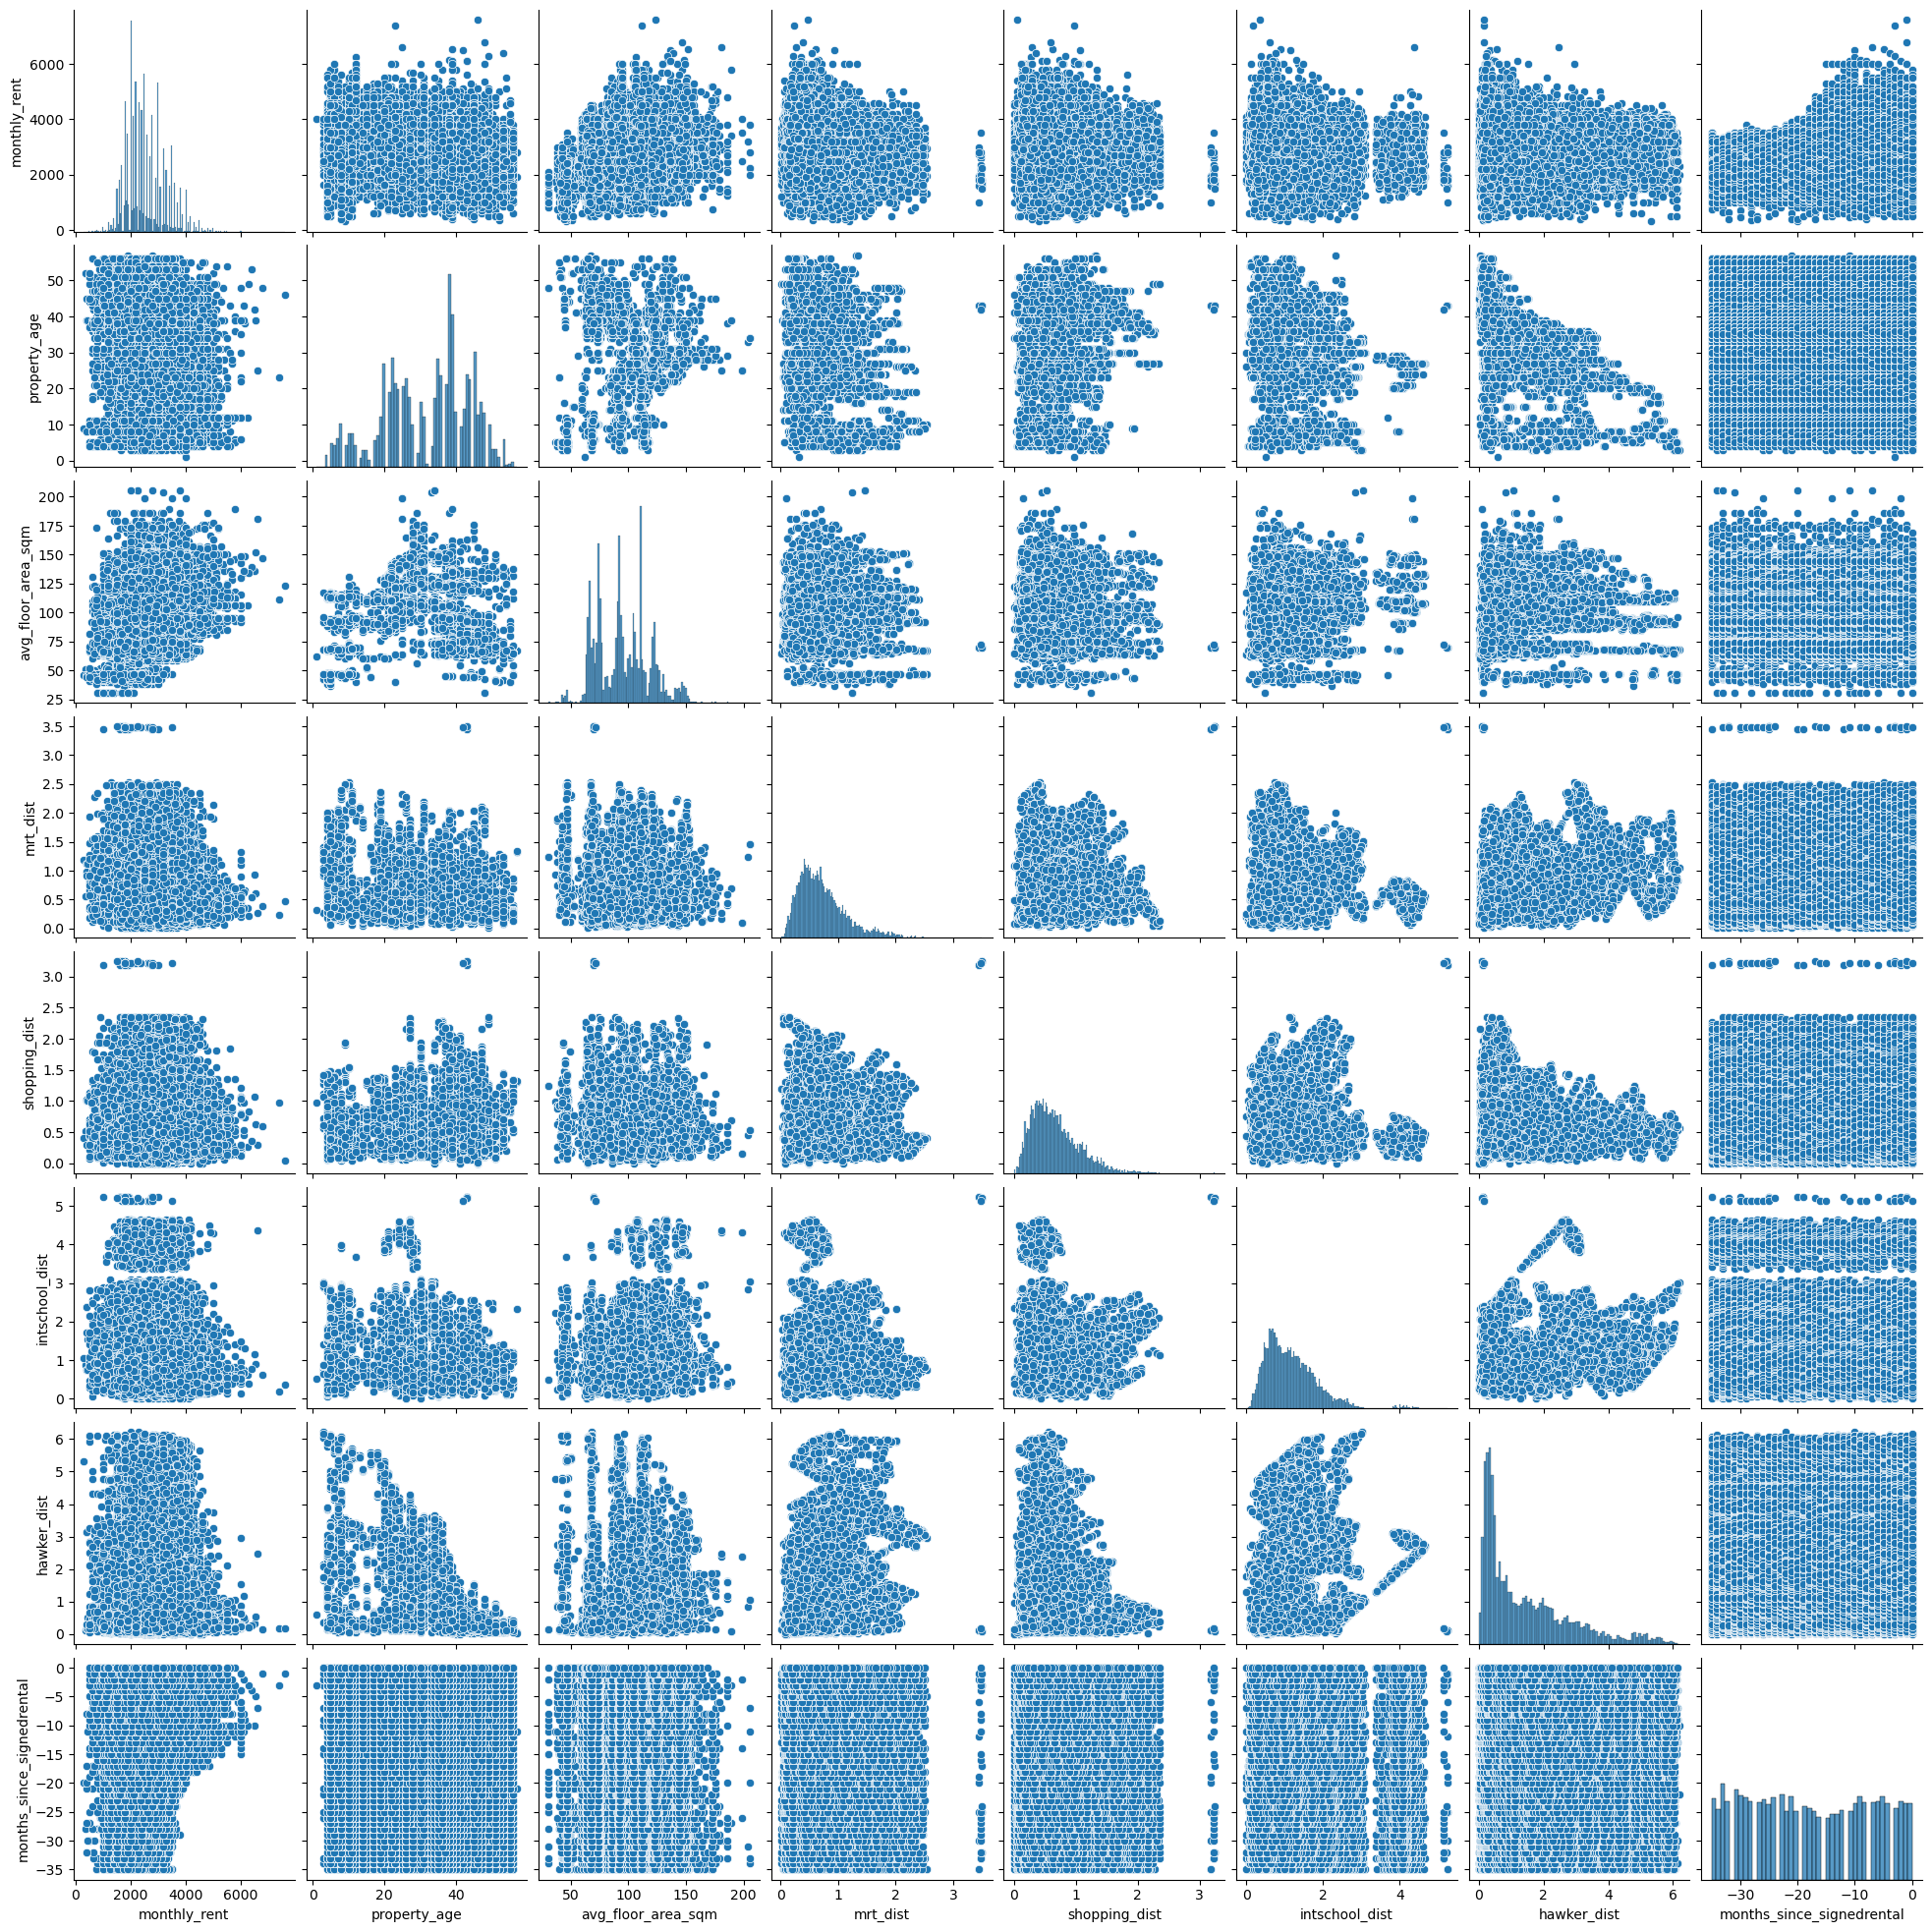

In [11]:
sns.pairplot(reduced_df)

## Data Modeling

In [12]:
rng = 1 #np.random.RandomState(1) # Use this as a random_state input for machine learning models 

### Model  with amenities

In [13]:
original_col = pd.get_dummies(reduced_df).columns
preprocessed_df = pd.get_dummies(reduced_df, drop_first=True, dtype=int)
dummy_var = set(original_col) - set(preprocessed_df.columns)

print('Dummy variables are', dummy_var)
preprocessed_df.head()

Dummy variables are {'town_ANG MO KIO', 'flat_type_1 ROOM'}


,monthly_rent,property_age,avg_floor_area_sqm,mrt_dist,shopping_dist,intschool_dist,hawker_dist,months_since_signedrental,town_BEDOK,town_BISHAN,...,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE
0,2000,45.0,92.0,1.329716,0.929260,1.529100,0.244028,-35,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1750,45.0,78.2,1.365741,0.954735,1.607337,0.344891,-35,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1750,45.0,74.5,1.270434,0.868254,1.562581,0.357068,-35,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2230,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2450,45.0,117.0,1.369690,0.969552,1.649779,0.401847,-35,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
preprocessed_df.columns = preprocessed_df.columns.str.replace(' ','_')
preprocessed_df.rename(columns={'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA'}, inplace=True)

x_variables = list(preprocessed_df.columns)
y_variable = 'monthly_rent'

try: x_variables.remove(y_variable)
except ValueError: pass

#### Regression: Simple

*R^2 0.522, not great. Tried log(y) but got lower R^2*

*intschool_dist and town_Geylang are not significant at the 1% level.*

In [15]:
linear_model = smf.ols(data=preprocessed_df, formula=f'{y_variable} ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     3080.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:42:39   Log-Likelihood:            -7.9761e+05
No. Observations:              104604   AIC:                         1.595e+06
Df Residuals:                  104566   BIC:                         1.596e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### Regression: Changing y variable to log

*R2 0.522, not great. Tried log(y) but got lower R2*

*intschool_dist and town_Geylang are not significant at the 1% level.*

In [16]:
try: x_variables.remove('intschool_dist')
except ValueError: pass

linear_model = smf.ols(data=preprocessed_df, formula=f'{y_variable} ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     3165.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:42:40   Log-Likelihood:            -7.9762e+05
No. Observations:              104604   AIC:                         1.595e+06
Df Residuals:                  104567   BIC:                         1.596e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Text(0.5, 1.0, 'Actual y vs Pred y')

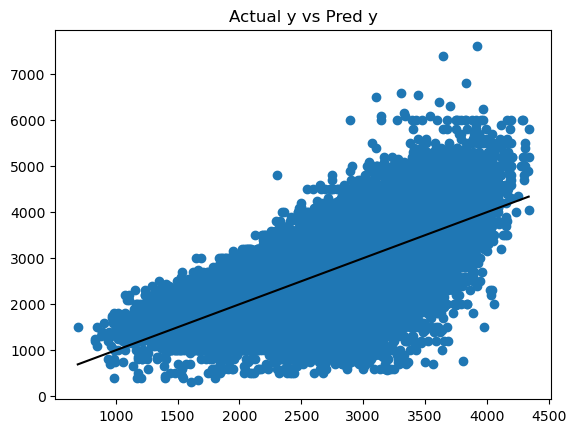

In [17]:
y = preprocessed_df[y_variable]
pred_y = linear_model.fittedvalues
plt.scatter(pred_y, y)
plt.plot([min(pred_y), max(pred_y)], [min(pred_y), max(pred_y)], color='black')
plt.title('Actual y vs Pred y')

### Residual Analysis

*Some evidence of heteroscedasticity when plotting residuals against pred*

*However, could not find similar evidence when plotting against any of the x variable*

*Suggesting some unexplained variance in the model, which is the reason for low R^2.*

*This could be the storey height of the rental, which we have no data on*

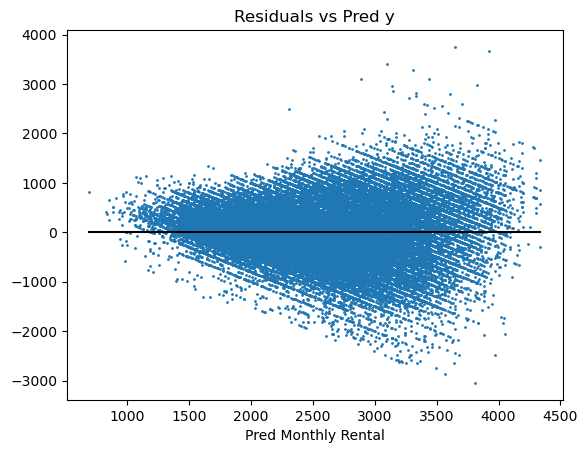

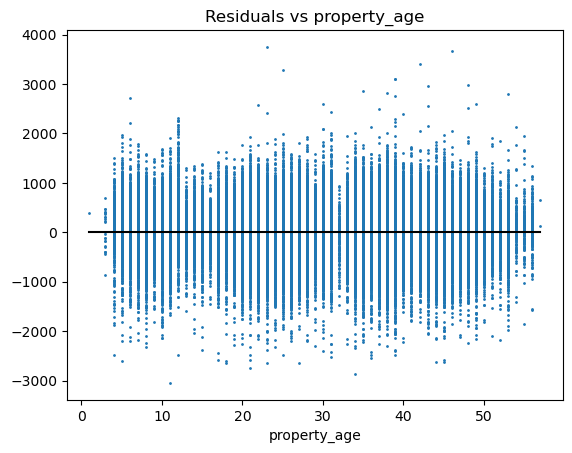

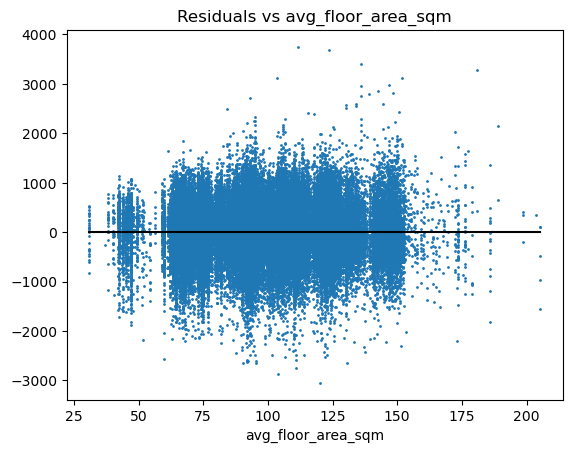

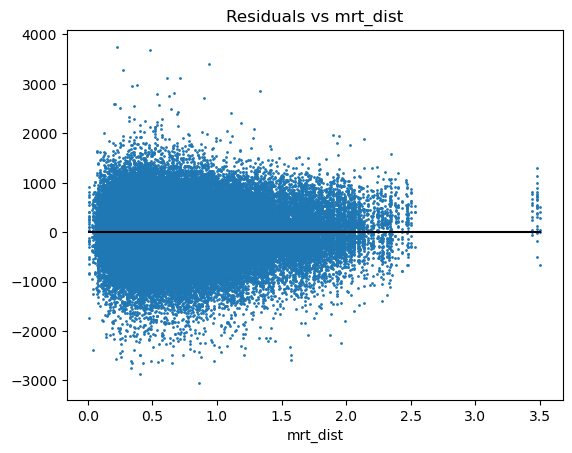

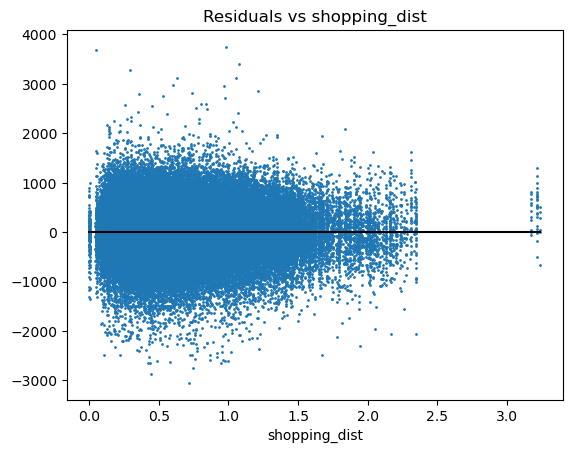

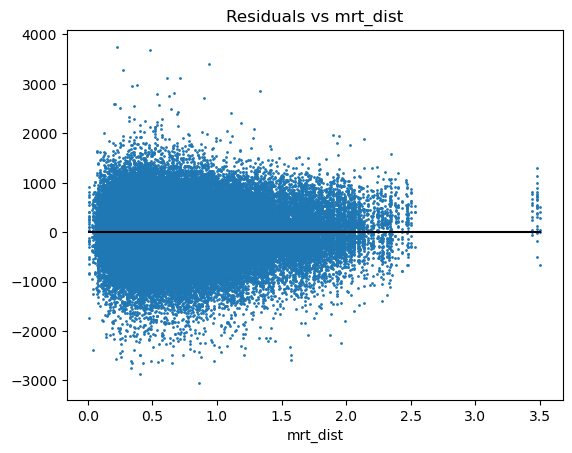

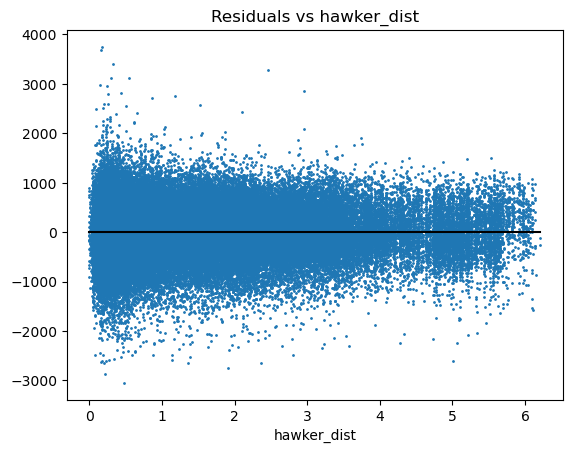

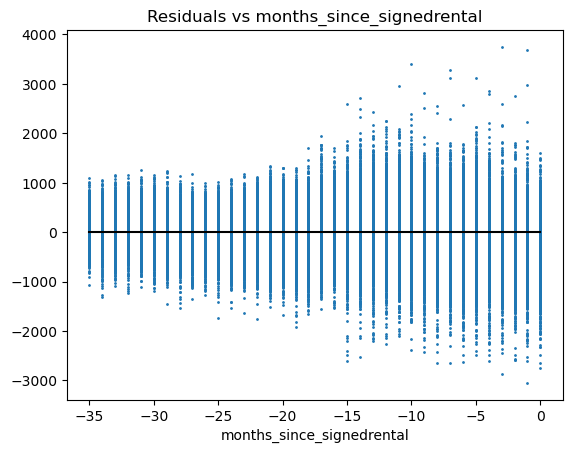

In [18]:
plt.scatter(pred_y, linear_model.resid, s=1)
plt.plot([min(pred_y),max(pred_y)],[0,0], color='black')
plt.title('Residuals vs Pred y')
plt.xlabel('Pred Monthly Rental')
plt.show()

for var in ['property_age', 'avg_floor_area_sqm', 'mrt_dist', 'shopping_dist', 
            'mrt_dist', 'hawker_dist', 'months_since_signedrental']:
    plt.scatter(preprocessed_df[var], linear_model.resid, s=1)
    plt.plot([min(preprocessed_df[var]),max(preprocessed_df[var])],[0,0], color='black')
    plt.title(f'Residuals vs {var}')
    plt.xlabel(var)
    plt.show()

##### Simple Regression - K-FOLD TESTING

In [19]:
# Prepare data
X = preprocessed_df.drop(columns=['monthly_rent']).to_numpy()
y = preprocessed_df['monthly_rent'].to_numpy()

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
lm = LinearRegression()


fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    lm.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = lm.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {lm.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()


Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.514
MAE: 383.786
RMSE: 498.916

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.515
MAE: 387.922
RMSE: 502.588

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.528
MAE: 377.386
RMSE: 489.166

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.522
MAE: 385.393
RMSE: 497.941

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.527
MAE: 379.374
RMSE: 491.159



### Alternative Modeling - Test on other models

Data Preparation

In [21]:
# Split dataset into features and target
X = preprocessed_df.drop(columns=['monthly_rent']).to_numpy()
y = preprocessed_df['monthly_rent'].to_numpy()

In [22]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

#### Regression: Ridge

In [23]:

# Define the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength

# Fit the model
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

# Calculate Adjusted R-squared
n, p = X.shape
adjusted_r_squared = 1 - (1 - r2_ridge) * (n - 1) / (n - p - 1)


print("Ridge Regression - R² score:", r2_ridge)
print(f"Ridge Regression - Adjusted R²: {adjusted_r_squared}")
print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)



Ridge Regression - R² score: 0.5143696531550542
Ridge Regression - Adjusted R²: 0.5141978160107314
Ridge Regression - MAE: 383.79688461508806
Ridge Regression - RMSE: 498.9441110921427


In [24]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    ridge_model.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = ridge_model.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {ridge_model.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()

Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.514
MAE: 383.797
RMSE: 498.944

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.515
MAE: 387.930
RMSE: 502.599

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.529
MAE: 377.353
RMSE: 489.157

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.522
MAE: 385.387
RMSE: 497.937

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.527
MAE: 379.393
RMSE: 491.177



##### Ridge - Fine Tuning (Grid search CV) and Model Evaluation

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the model
model = Ridge()

# Define the hyperparameters to tune
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, y)

# Best hyperparameter
print(grid_search.best_params_)


{'alpha': 0.001}


In [26]:
para = grid_search.best_params_['alpha']

In [27]:
from sklearn.linear_model import Ridge

# Define the Ridge Regression model
ridge_model2 = Ridge(alpha=para)  # alpha is the regularization strength

# Fit the model
ridge_model2.fit(X_train, y_train)

# Predict
y_pred_ridge2 = ridge_model2.predict(X_test)

# Evaluate
r2_ridge2 = r2_score(y_test, y_pred_ridge2)
rmse_ridge2 = np.sqrt(mean_squared_error(y_test, y_pred_ridge2))
mae_ridge2 = mean_absolute_error(y_test, y_pred_ridge2)
# Calculate Adjusted R-squared
n, p = X.shape
adjusted_r_squared = 1 - (1 - r2_ridge2) * (n - 1) / (n - p - 1)

print("Ridge Regression - R² score:", r2_ridge2)
print(f"Ridge Regression - Adjusted R²: {adjusted_r_squared}")
print("Ridge Regression - MAE:", mae_ridge2)
print("Ridge Regression - RMSE:", rmse_ridge2)



Ridge Regression - R² score: 0.5266639529407818
Ridge Regression - Adjusted R²: 0.5264964660545932
Ridge Regression - MAE: 379.37368182517065
Ridge Regression - RMSE: 491.15906075597053


##### Ridge - K-Fold Testing

In [28]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
ridge_model2 = Ridge(alpha=para) 

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    ridge_model2.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = ridge_model2.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {ridge_model2.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()

Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.514
MAE: 383.786
RMSE: 498.916

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.515
MAE: 387.922
RMSE: 502.588

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.528
MAE: 377.386
RMSE: 489.166

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.522
MAE: 385.393
RMSE: 497.941

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.527
MAE: 379.374
RMSE: 491.159



#### Regression: Lasso

In [29]:
from sklearn.linear_model import Lasso

# Define the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # alpha is the regularization strength

# Fit the model
lasso_model.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
n, p = X.shape
adjusted_r_squared = 1 - (1 - r2_lasso) * (n - 1) / (n - p - 1)

print("Lasso Regression - R² score:", r2_lasso)
print(f"Lasso Regression - Adjusted R²: {adjusted_r_squared}")
print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)


Lasso Regression - R² score: 0.5264237860109353
Lasso Regression - Adjusted R²: 0.5262562141432383
Lasso Regression - MAE: 379.4448641728188
Lasso Regression - RMSE: 491.2836500463959


##### Lasso - K-Fold Testing

In [30]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
lasso_model = Lasso(alpha=0.1)


fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    lasso_model.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = lasso_model.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {lasso_model.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e+08, tolerance: 4.301e+06
  model = cd_fast.enet_coordinate_descent(


Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.513
MAE: 384.154
RMSE: 499.420

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.514
MAE: 388.042
RMSE: 502.759

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.528
MAE: 377.438
RMSE: 489.304

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.522
MAE: 385.454
RMSE: 498.023

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.526
MAE: 379.445
RMSE: 491.284



#### Regression: Decision Tree

##### Decision Tree - Plot of R^2 vs Depth

In [31]:
# Lists to store the results
dt_depths = []
train_r2_scores = []
test_r2_scores = []

for i in range(1,16):
    dtr = DecisionTreeRegressor( max_depth=i, random_state=rng )
    dtr.fit( X_train, y_train )
    y_train_pred = dtr.predict( X_train )
    y_test_pred = dtr.predict( X_test )
    
    dt_depths.append(i)
    train_r2_scores.append(r2_score(y_train, y_train_pred))
    test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    print('Depth', i)
    print('Train MSE', int(mean_squared_error( y_train, y_train_pred )))
    print(f'Train R2 {r2_score( y_train, y_train_pred ):.3f}')
    print('Test MSE', int(mean_squared_error( y_test, y_test_pred )))
    print(f'Test R2 {r2_score( y_test, y_test_pred ):.3f}')
    print()


Depth 1
Train MSE 370940
Train R2 0.279
Test MSE 363301
Test R2 0.287

Depth 2
Train MSE 315618
Train R2 0.387
Test MSE 304678
Test R2 0.402

Depth 3
Train MSE 299870
Train R2 0.417
Test MSE 290613
Test R2 0.430

Depth 4
Train MSE 287058
Train R2 0.442
Test MSE 277717
Test R2 0.455

Depth 5
Train MSE 271950
Train R2 0.472
Test MSE 261383
Test R2 0.487

Depth 6
Train MSE 260934
Train R2 0.493
Test MSE 251813
Test R2 0.506

Depth 7
Train MSE 252521
Train R2 0.509
Test MSE 245900
Test R2 0.518

Depth 8
Train MSE 245375
Train R2 0.523
Test MSE 243833
Test R2 0.522

Depth 9
Train MSE 237770
Train R2 0.538
Test MSE 243067
Test R2 0.523

Depth 10
Train MSE 229738
Train R2 0.554
Test MSE 244356
Test R2 0.521

Depth 11
Train MSE 220878
Train R2 0.571
Test MSE 248049
Test R2 0.513

Depth 12
Train MSE 210844
Train R2 0.590
Test MSE 254647
Test R2 0.500

Depth 13
Train MSE 199451
Train R2 0.613
Test MSE 263657
Test R2 0.483

Depth 14
Train MSE 187086
Train R2 0.637
Test MSE 273073
Test R2 0.464

D

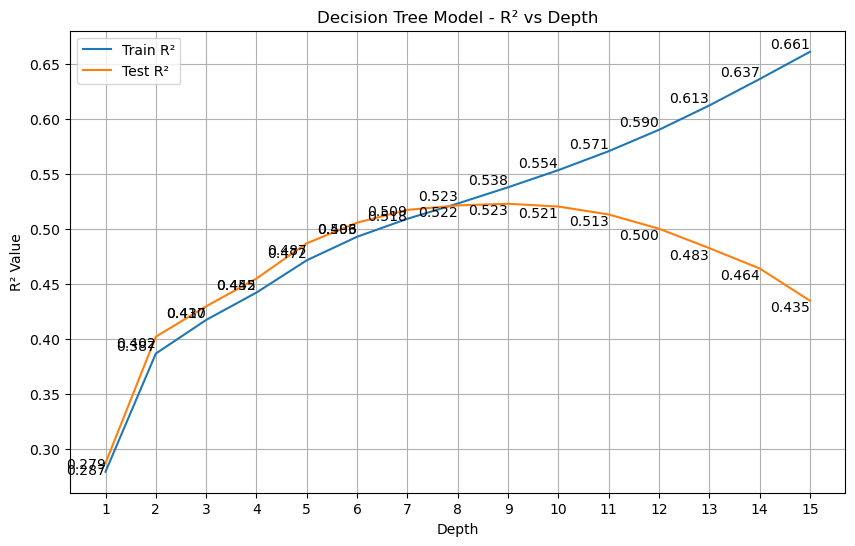

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=dt_depths, y=train_r2_scores, label='Train R²')
sns.lineplot(x=dt_depths, y=test_r2_scores, label='Test R²')

# Annotating data points
for i in range(len(dt_depths)):
    plt.text(dt_depths[i], train_r2_scores[i], f'{train_r2_scores[i]:.3f}', ha='right', va='bottom')
    plt.text(dt_depths[i], test_r2_scores[i], f'{test_r2_scores[i]:.3f}', ha='right', va='top')

plt.title('Decision Tree Model - R² vs Depth')
plt.xlabel('Depth')
plt.ylabel('R² Value')
plt.xticks(dt_depths)
plt.legend()
plt.grid(True)
plt.show()

'''
Varying across Decision Trees of varying depth, we see that overfitting starts to set in around a max depth of 8. The maximum R2 achieved is only about 0.5 which is not much better than OLS. 
'''

##### Decision Tree - Model Evaluation

In [33]:
tree_reg = DecisionTreeRegressor( max_depth=8, random_state=rng )
tree_reg.fit( X_train, y_train )

y_pred_dt = tree_reg.predict( X_test )

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
n, p = X.shape
adjusted_r_squared = 1 - (1 - r2_dt) * (n - 1) / (n - p - 1)

print("Decision Tree Regression - R² score:", r2_dt)
print(f"Decision Tree Regression - Adjusted R²: {adjusted_r_squared}")
print("Decision Tree Regression - MAE:", mae_dt)
print("Decision Tree Regression - RMSE:", rmse_dt)


Decision Tree Regression - R² score: 0.5215703819778601
Decision Tree Regression - Adjusted R²: 0.5214010927646664
Decision Tree Regression - MAE: 378.77823280834826
Decision Tree Regression - RMSE: 493.79467151463064


##### Decision Tree - K-Fold Testing

In [35]:
from sklearn.model_selection import KFold

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)

# Prepare data
X = preprocessed_df.drop(columns=['monthly_rent']).to_numpy()
y = preprocessed_df['monthly_rent'].to_numpy()

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    tree_reg.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = tree_reg.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {tree_reg.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()


Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.496
MAE: 387.047
RMSE: 508.200

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.502
MAE: 389.966
RMSE: 508.866

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.513
MAE: 380.676
RMSE: 497.041

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.507
MAE: 387.241
RMSE: 505.764

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.522
MAE: 378.778
RMSE: 493.795



#### Regression: Random Forest

In [36]:
# Lists to store the results
rf_depths = []
train_r2_scores = []
test_r2_scores = []

for i in range(1,16):
    rf = RandomForestRegressor( max_depth=i, random_state=rng )
    rf.fit( X_train, y_train )
    y_train_pred = rf.predict( X_train )
    y_test_pred = rf.predict( X_test )
    
    rf_depths.append(i)
    train_r2_scores.append(r2_score(y_train, y_train_pred))
    test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    print('Depth', i)
    print('Train MSE', int(mean_squared_error( y_train, y_train_pred )))
    print(f'Train R2 {r2_score( y_train, y_train_pred ):.3f}')
    print('Test MSE', int(mean_squared_error( y_test, y_test_pred )))
    print(f'Test R2 {r2_score( y_test, y_test_pred ):.3f}')
    print()


Depth 1
Train MSE 370088
Train R2 0.281
Test MSE 362484
Test R2 0.289

Depth 2
Train MSE 314524
Train R2 0.389
Test MSE 303676
Test R2 0.404

Depth 3
Train MSE 296021
Train R2 0.425
Test MSE 286216
Test R2 0.438

Depth 4
Train MSE 280566
Train R2 0.455
Test MSE 270709
Test R2 0.469

Depth 5
Train MSE 266842
Train R2 0.482
Test MSE 256586
Test R2 0.497

Depth 6
Train MSE 254916
Train R2 0.505
Test MSE 246333
Test R2 0.517

Depth 7
Train MSE 246063
Train R2 0.522
Test MSE 240378
Test R2 0.528

Depth 8
Train MSE 237495
Train R2 0.539
Test MSE 235750
Test R2 0.537

Depth 9
Train MSE 228512
Train R2 0.556
Test MSE 232461
Test R2 0.544

Depth 10
Train MSE 218844
Train R2 0.575
Test MSE 230203
Test R2 0.548

Depth 11
Train MSE 208261
Train R2 0.595
Test MSE 229139
Test R2 0.550

Depth 12
Train MSE 196713
Train R2 0.618
Test MSE 229165
Test R2 0.550

Depth 13
Train MSE 184306
Train R2 0.642
Test MSE 229678
Test R2 0.549

Depth 14
Train MSE 171406
Train R2 0.667
Test MSE 230840
Test R2 0.547

D

##### Random Forest - Plot of  R² vs Depth

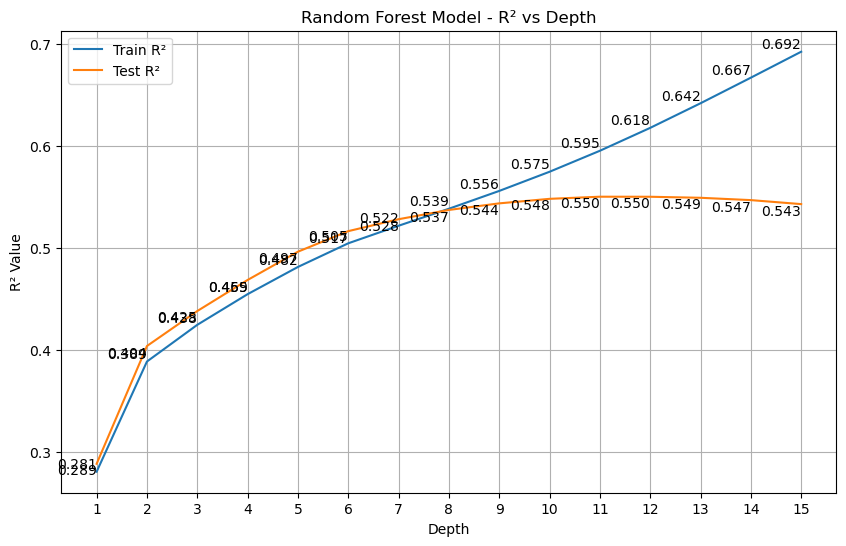

In [37]:
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=rf_depths, y=train_r2_scores, label='Train R²')
sns.lineplot(x=rf_depths, y=test_r2_scores, label='Test R²')

# Annotating data points
for i in range(len(rf_depths)):
    plt.text(rf_depths[i], train_r2_scores[i], f'{train_r2_scores[i]:.3f}', ha='right', va='bottom')
    plt.text(rf_depths[i], test_r2_scores[i], f'{test_r2_scores[i]:.3f}', ha='right', va='top')

plt.title('Random Forest Model - R² vs Depth')
plt.xlabel('Depth')
plt.ylabel('R² Value')
plt.xticks(rf_depths)
plt.legend()
plt.grid(True)
plt.show()

##### Random Forest - Modeling Evaluation

In [38]:
from sklearn.ensemble import RandomForestRegressor

rnd_clf = RandomForestRegressor( max_depth=10, random_state=rng )

rnd_clf.fit( X_train, y_train )

y_pred_rf = rnd_clf.predict( X_test )

In [39]:
# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
n, p = X.shape
adjusted_r_squared = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

print("Random Forest Regression - R² score:", r2_rf)
print(f"Random Forest Regression - Adjusted R²: {adjusted_r_squared}")
print("Random Forest Regression - MAE:", mae_rf)
print("Random Forest Regression - RMSE:", rmse_rf)


Random Forest Regression - R² score: 0.5483140139128451
Random Forest Regression - Adjusted R²: 0.5481541877601259
Random Forest Regression - MAE: 367.4733616006526
Random Forest Regression - RMSE: 479.79495670380226


##### Random Forest - K-Fold Testing

In [40]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
rnd_clf = RandomForestRegressor( max_depth=10, random_state=rng )

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    rnd_clf.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = rnd_clf.predict(X_test)
    errors = y_pred - y_test
    mse = mean_squared_error(y_test, y_pred)
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {rnd_clf.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()


Fold 1, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.526
MAE: 375.134
RMSE: 492.847

Fold 2, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.533
MAE: 377.471
RMSE: 493.192

Fold 3, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.541
MAE: 368.733
RMSE: 482.683

Fold 4, 83683 train datapoints, Test: 20921 test datapoints
R2: 0.539
MAE: 373.363
RMSE: 488.945

Fold 5, 83684 train datapoints, Test: 20920 test datapoints
R2: 0.548
MAE: 367.473
RMSE: 479.795



### Baseline Model (without amenities)

#### Dataframe Preparation for baseline modeling without amenities

In [41]:
# Baseline dataset without amenities

baseline_df = rentals_dataset[['town', 'flat_type', 'property_age', 'avg_floor_area_sqm',
                              'months_since_signedrental', 'monthly_rent']]

baseline_df

,town,flat_type,property_age,avg_floor_area_sqm,months_since_signedrental,monthly_rent
0,ANG MO KIO,4 ROOM,45.0,92.0,-35,2000
1,ANG MO KIO,3 ROOM,45.0,78.2,-35,1750
2,ANG MO KIO,3 ROOM,45.0,74.5,-35,1750
3,ANG MO KIO,5 ROOM,45.0,117.0,-35,2230
4,ANG MO KIO,5 ROOM,45.0,117.0,-35,2450
...,...,...,...,...,...,...
109314,QUEENSTOWN,4 ROOM,23.0,89.3,0,4100
109315,WOODLANDS,4 ROOM,23.0,103.0,0,3300
109316,CHOA CHU KANG,4 ROOM,30.0,106.2,0,2950
109317,YISHUN,4 ROOM,36.0,86.5,0,3200


In [42]:
base_original_col = pd.get_dummies(baseline_df).columns
base_preprocessed_df = pd.get_dummies(baseline_df, drop_first=True, dtype=int)
base_dummy_var = set(base_original_col) - set(base_preprocessed_df.columns)

print('Dummy variables are', base_dummy_var)
base_preprocessed_df.head()

Dummy variables are {'town_ANG MO KIO', 'flat_type_1 ROOM'}


,property_age,avg_floor_area_sqm,months_since_signedrental,monthly_rent,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE
0,45.0,92.0,-35,2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,45.0,78.2,-35,1750,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,45.0,74.5,-35,1750,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,45.0,117.0,-35,2230,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,45.0,117.0,-35,2450,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
base_preprocessed_df.columns = base_preprocessed_df.columns.str.replace(' ','_')
base_preprocessed_df.rename(columns={'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA'}, inplace=True)

base_x_variables = list(base_preprocessed_df.columns)
base_y_variable = 'monthly_rent'

try: base_x_variables.remove(base_y_variable)
except ValueError: pass


In [44]:
# Prepare data
base_X = base_preprocessed_df.drop(columns=['monthly_rent']).to_numpy()
base_y = base_preprocessed_df['monthly_rent'].to_numpy()

#### Baseline Regression: Simple

In [45]:
base_linear_model = smf.ols(data=base_preprocessed_df, formula=f'{base_y_variable} ~ {"+".join(base_x_variables)}').fit()

print(base_linear_model.summary())
print(f'Dummy Variables: {base_dummy_var}')


                            OLS Regression Results                            
Dep. Variable:           monthly_rent   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     3355.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:49:34   Log-Likelihood:            -7.9840e+05
No. Observations:              104604   AIC:                         1.597e+06
Df Residuals:                  104570   BIC:                         1.597e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### Baseline Regression: Random Forest

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_preprocessed_df[base_x_variables], base_preprocessed_df[base_y_variable], test_size=0.20, random_state=rng )

# Lists to store the results
base_rf_depths = []
base_train_r2_scores = []
base_test_r2_scores = []

for i in range(1,16):
    rf = RandomForestRegressor( max_depth=i, random_state=rng )
    rf.fit( base_X_train, base_y_train )
    base_y_train_pred = rf.predict( base_X_train )
    base_y_test_pred = rf.predict( base_X_test )
    
    base_rf_depths.append(i)
    base_train_r2_scores.append(r2_score( base_y_train, base_y_train_pred ))
    base_test_r2_scores.append(r2_score( base_y_test, base_y_test_pred ))
    
    print('Depth', i)
    print('Train MSE', int(mean_squared_error( base_y_train, base_y_train_pred )))
    print(f'Train R2 {r2_score( base_y_train, base_y_train_pred ):.3f}')
    print('Test MSE', int(mean_squared_error( base_y_test, base_y_test_pred )))
    print(f'Test R2 {r2_score( base_y_test, base_y_test_pred ):.3f}')
    print()


Depth 1
Train MSE 366824
Train R2 0.286
Test MSE 371617
Test R2 0.275

Depth 2
Train MSE 310254
Train R2 0.396
Test MSE 316691
Test R2 0.382

Depth 3
Train MSE 291713
Train R2 0.432
Test MSE 298948
Test R2 0.417

Depth 4
Train MSE 277629
Train R2 0.460
Test MSE 285633
Test R2 0.443

Depth 5
Train MSE 267373
Train R2 0.480
Test MSE 276051
Test R2 0.461

Depth 6
Train MSE 258431
Train R2 0.497
Test MSE 267794
Test R2 0.478

Depth 7
Train MSE 251563
Train R2 0.511
Test MSE 262177
Test R2 0.489

Depth 8
Train MSE 244883
Train R2 0.524
Test MSE 256989
Test R2 0.499

Depth 9
Train MSE 238343
Train R2 0.536
Test MSE 253057
Test R2 0.506

Depth 10
Train MSE 232175
Train R2 0.548
Test MSE 250415
Test R2 0.512

Depth 11
Train MSE 225639
Train R2 0.561
Test MSE 248607
Test R2 0.515

Depth 12
Train MSE 218925
Train R2 0.574
Test MSE 247672
Test R2 0.517

Depth 13
Train MSE 211974
Train R2 0.588
Test MSE 247298
Test R2 0.518

Depth 14
Train MSE 204849
Train R2 0.601
Test MSE 247168
Test R2 0.518

D

##### Baseline Random Forest - R² vs Depth

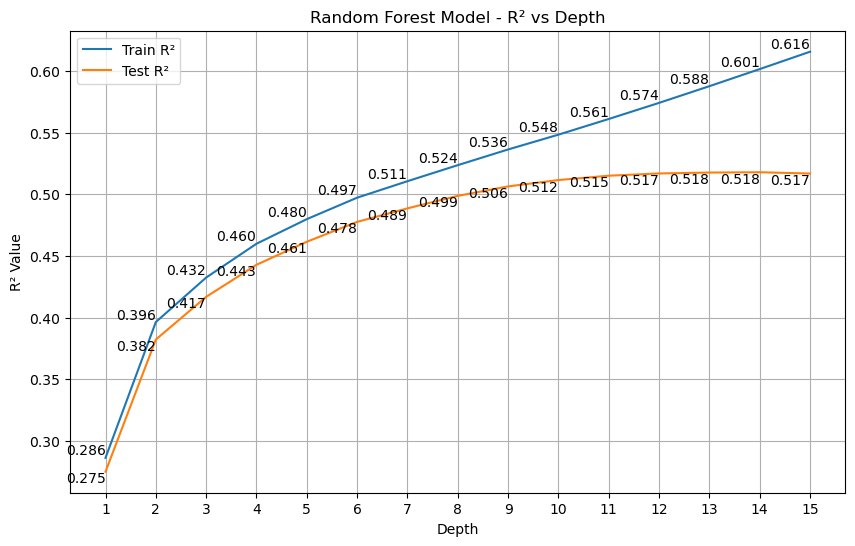

In [47]:
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=base_rf_depths, y=base_train_r2_scores, label='Train R²')
sns.lineplot(x=base_rf_depths, y=base_test_r2_scores, label='Test R²')

# Annotating data points
for i in range(len(base_rf_depths)):
    plt.text(base_rf_depths[i], base_train_r2_scores[i], f'{base_train_r2_scores[i]:.3f}', ha='right', va='bottom')
    plt.text(base_rf_depths[i], base_test_r2_scores[i], f'{base_test_r2_scores[i]:.3f}', ha='right', va='top')

plt.title('Random Forest Model - R² vs Depth')
plt.xlabel('Depth')
plt.ylabel('R² Value')
plt.xticks(base_rf_depths)
plt.legend()
plt.grid(True)
plt.show()

##### Baseline Random Forest - Modeling Evaluation

In [48]:
from sklearn.ensemble import RandomForestRegressor

base_rnd_clf = RandomForestRegressor( max_depth=12, random_state=rng )

base_rnd_clf.fit( base_X_train, base_y_train )

base_y_pred_rf = base_rnd_clf.predict( base_X_test )

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate
base_r2_rf = r2_score( base_y_test, base_y_pred_rf )
base_mae_rf = mean_absolute_error( base_y_test, base_y_pred_rf )
base_rmse_rf = np.sqrt(mean_squared_error( base_y_test, base_y_pred_rf))
n, p = base_X.shape
base_adjusted_r_squared = 1 - (1 - base_r2_rf) * (n - 1) / (n - p - 1)

print("Random Forest Regression - R² score:", base_r2_rf)
print(f"Random Forest Regression - Adjusted R²: {base_adjusted_r_squared}")
print("Random Forest Regression - MAE:", base_mae_rf)
print("Random Forest Regression - RMSE:", base_rmse_rf)


Random Forest Regression - R² score: 0.5168515439257835
Random Forest Regression - Adjusted R²: 0.5166990728628549
Random Forest Regression - MAE: 379.74325066254113
Random Forest Regression - RMSE: 497.6675115014164
